<a href="https://colab.research.google.com/github/tnewtont/Detecting_Palm_Oil_Plantations_Neural_Networks/blob/main/WiDS_Project_VGG19_gridsearch_ipynb_(0_9701480958681058).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Training With VGG19 and Grid Search**

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter, ImageEnhance
import json
import pickle
import io, os
import gzip
from google.colab import files
from tensorflow.keras import datasets, layers, models
from keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import VGG16
from sklearn.metrics import roc_auc_score
import tensorflow as tf
import random
from sklearn.metrics import confusion_matrix, classification_report, precision_score
from sklearn.metrics import recall_score, f1_score, precision_recall_curve, average_precision_score, auc, roc_curve
import seaborn as sns
from keras import regularizers
from keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, GaussianNoise, RandomFlip, RandomZoom, RandomRotation, Conv2D, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import HeNormal
import tensorflow.keras.backend
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)


In [3]:
# Load our pickled training set
with gzip.open('/content/drive/MyDrive/images_labels.pickle.gz', 'rb') as f:
  images, labels = pickle.load(f)

We will train-test split our dataset two times so that we have a training and a validation dataset.

In [4]:
xtrain, xtest, ytrain, ytest = train_test_split(images, labels, test_size = 0.2, random_state = 42, stratify = labels)

In [5]:
xtrain, xval, ytrain, yval = train_test_split(xtrain, ytrain, test_size = 0.2, random_state = 42, stratify = ytrain)

In [6]:
# Using tf.data.AUTOTUNE optimizes the performance of our datasets while training
train_dataset = tf.data.Dataset.from_tensor_slices((xtrain, ytrain)).batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = tf.data.Dataset.from_tensor_slices((xval, yval)).batch(32).prefetch(tf.data.AUTOTUNE)

In [7]:
# Load our pickled holdout dataset
with gzip.open('/content/drive/MyDrive/holdout_images_labels.pickle.gz', 'rb') as f:
    ho_images_arr, ho_labels_arr = pickle.load(f)

In [8]:
ho_dataset = (ho_images_arr, ho_labels_arr)

In [9]:
x_holdout, y_holdout = ho_dataset

We will initialize a custom callback that keeps track of several metrics as our model is training.

In [10]:
class PrecisionRecallHoldoutCallback(tf.keras.callbacks.Callback):
    def __init__(self, holdout_data):
        self.holdout_data = holdout_data  # Holdout data (X, y)
        self.precision_0 = []
        self.recall_0 = []
        self.f1_0 = []  # F1 score for Class 0
        self.precision_1 = []
        self.recall_1 = []
        self.f1_1 = []  # F1 score for Class 1
        self.roc_auc_scores = []  # ROC-AUC scores across epochs
        self.ap_scores = [] # AP scores across epochs

    def on_epoch_end(self, epoch, logs=None):
        x_holdout, y_holdout = self.holdout_data
        predictions = self.model.predict(x_holdout).ravel() # Flatten out
        predictions_binary = (predictions > 0.5).astype(int)  # Convert probabilities to binary predictions

        # Compute metrics for Class 0
        precision_0 = precision_score(y_holdout, predictions_binary, pos_label=0)
        recall_0 = recall_score(y_holdout, predictions_binary, pos_label=0)
        f1_0 = f1_score(y_holdout, predictions_binary, pos_label=0)

        # Compute metrics for Class 1
        precision_1 = precision_score(y_holdout, predictions_binary, pos_label=1)
        recall_1 = recall_score(y_holdout, predictions_binary, pos_label=1)
        f1_1 = f1_score(y_holdout, predictions_binary, pos_label=1)

        # Compute ROC-AUC score
        roc_auc = roc_auc_score(y_holdout, predictions)
        # Compute Average Precision (AP) score
        ap_score = average_precision_score(y_holdout, predictions)

        # Log metrics
        print(f"\nEpoch {epoch + 1}: Holdout Precision (Class 0) = {precision_0:.4f}, Recall (Class 0) = {recall_0:.4f}, F1 (Class 0) = {f1_0:.4f}")
        print(f"Epoch {epoch + 1}: Holdout Precision (Class 1) = {precision_1:.4f}, Recall (Class 1) = {recall_1:.4f}, F1 (Class 1) = {f1_1:.4f}")
        print(f"Epoch {epoch + 1}: Holdout ROC-AUC Score = {roc_auc:.4f}, Average Precision (AP) Score = {ap_score:.4f}")

        # Append metrics to lists
        self.precision_0.append(precision_0)
        self.recall_0.append(recall_0)
        self.f1_0.append(f1_0)
        self.precision_1.append(precision_1)
        self.recall_1.append(recall_1)
        self.f1_1.append(f1_1)
        self.roc_auc_scores.append(roc_auc)
        self.ap_scores.append(ap_score)

        # Optionally store metrics in logs for further analysis
        logs['holdout_precision_0'] = precision_0
        logs['holdout_recall_0'] = recall_0
        logs['holdout_f1_0'] = f1_0
        logs['holdout_precision_1'] = precision_1
        logs['holdout_recall_1'] = recall_1
        logs['holdout_f1_1'] = f1_1
        logs['holdout_roc_auc'] = roc_auc
        logs['holdout_ap'] = ap_score

Here, we are utilizing VGG19, which is a pre-trained model. In particular, we will perform a grid search of two hyperparameters: L2 regularization, which gets applied to the final dense layer, and the number of epochs. Besides L2 regularization, using He / Kaiming normalization, dropouts, and lower learning rate helps prevent our model from overfitting.

In [11]:
l2_values = [0.03851, 0.03852, 0.03853, 0.03854, 0.03855]
epoch_values = [3, 4]
best_model_path = None
best_score = None
best_params = None
best_history = None
best_metrics = None
results = []

for l2 in l2_values:
    for epochs in epoch_values:
        print(f"Testing L2 = {l2}, epochs = {epochs}")

        # Define model
        vgg19 = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
        for layer in vgg19.layers:
            layer.trainable = False

        fl = Flatten()(vgg19.layers[-1].output)
        dl1 = Dense(300, activation='relu', kernel_initializer=HeNormal())(fl)
        dropout1 = Dropout(0.4)(dl1)
        dl2 = Dense(200, activation='relu', kernel_initializer=HeNormal())(dropout1)
        dropout2 = Dropout(0.3)(dl2)
        dl3 = Dense(100, activation='relu', kernel_initializer=HeNormal())(dropout2)
        dropout3 = Dropout(0.25)(dl3)
        dl4 = Dense(50, activation='relu', kernel_initializer=HeNormal())(dropout3)
        dropout4 = Dropout(0.25)(dl4)
        dl5 = Dense(25, activation='relu', kernel_initializer=HeNormal())(dropout4)
        dropout5 = Dropout(0.2)(dl5)
        ol = Dense(1, activation='sigmoid', kernel_initializer=HeNormal(),
                   kernel_regularizer=regularizers.l2(l2))(dropout5)
        model = Model(inputs=vgg19.input, outputs=ol)

        # Compile
        model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate = 1e-4, weight_decay = 5e-5),
                      loss='binary_crossentropy',
                      metrics=['accuracy', tf.keras.metrics.AUC(name='roc_auc', curve='ROC')])

        # Train
        holdout_callback = PrecisionRecallHoldoutCallback((x_holdout, y_holdout))
        history = model.fit(
            train_dataset,
            epochs=epochs,
            validation_data=val_dataset,
            callbacks=[holdout_callback],
            verbose=1
        )

        # Evaluate
        roc_auc_score_ho = holdout_callback.roc_auc_scores[-1]
        ap_score = holdout_callback.ap_scores[-1]
        f1_class_0 = holdout_callback.f1_0[-1]
        f1_class_1 = holdout_callback.f1_1[-1]
        avg_f1_score = (f1_class_0 + f1_class_1) / 2


        x_holdout, y_holdout = ho_dataset
        predictions = model.predict(x_holdout)
        predictions = (predictions > 0.5).astype(int)

        precision_0 = precision_score(y_holdout, predictions, pos_label=0)
        recall_0 = recall_score(y_holdout, predictions, pos_label=0)

        precision_1 = precision_score(y_holdout, predictions, pos_label=1)
        recall_1 = recall_score(y_holdout, predictions, pos_label=1)

        print(f"L2 = {l2}, epochs = {epochs}: ROC-AUC = {roc_auc_score_ho:.4f}, "
              f"F1 (Class 0) = {f1_class_0:.4f}, F1 (Class 1) = {f1_class_1:.4f}, "
              f"AP score = {ap_score:.4f}, "
              f"Average F1 Score = {avg_f1_score:.4f}")

        # Append results
        results.append({
            'l2': l2,
            'epochs': epochs,
            'roc_auc': roc_auc_score_ho,
            'ap_score': ap_score,
            'f1_class_0': f1_class_0,
            'f1_class_1': f1_class_1,
            'avg_f1_score': avg_f1_score,
            'precision_0': precision_0,
            'recall_0': recall_0,
            'precision_1': precision_1,
            'recall_1': recall_1
        })

        # Track best metrics
        if best_score is None or avg_f1_score > best_score:
            print("\nUpdating best model.\n")
            best_score = avg_f1_score
            best_metrics = [precision_0, recall_0, precision_1, recall_1, f1_class_0, f1_class_1, ap_score]
            best_params = {'l2': l2, 'epochs': epochs}
            best_history = history.history  # Save the training history of the best model
            model.save('wids_gs_best_mod.keras')  # Save the best model

        # Clear session
        tf.keras.backend.clear_session()

# Save results and best history
pd.DataFrame(results).to_csv('wids_gs_results.csv', index=False)
with open('wids_gs_best_train_history.json', 'w') as f:
    json.dump(best_history, f)

print(f"Best parameters: {best_params}")
print(f"Best holdout metrics: Precision_0 = {best_metrics[0]:.4f}, Recall_0 = {best_metrics[1]:.4f}, "
      f"Precision_1 = {best_metrics[2]:.4f}, Recall_1 = {best_metrics[3]:.4f}, "
      f"F1_0 = {best_metrics[4]:.4f}, F1_1 = {best_metrics[5]:.4f}, "
      f"AP score = {best_metrics[6]:.4f}")


Testing L2 = 0.03851, epochs = 3
Epoch 1/3
69/69 ━━━━━━━━━━━━━━━━━━━━ 11s 146ms/step

Epoch 1: Holdout Precision (Class 0) = 0.8493, Recall (Class 0) = 0.6419, F1 (Class 0) = 0.7312
Epoch 1: Holdout Precision (Class 1) = 0.7122, Recall (Class 1) = 0.8861, F1 (Class 1) = 0.7897
Epoch 1: Holdout ROC-AUC Score = 0.8860, Average Precision (AP) Score = 0.8952
238/238 ━━━━━━━━━━━━━━━━━━━━ 76s 235ms/step - accuracy: 0.5596 - loss: 1.4361 - roc_auc: 0.5812 - val_accuracy: 0.6612 - val_loss: 0.6829 - val_roc_auc: 0.7189 - holdout_precision_0: 0.8493 - holdout_recall_0: 0.6419 - holdout_f1_0: 0.7312 - holdout_precision_1: 0.7122 - holdout_recall_1: 0.8861 - holdout_f1_1: 0.7897 - holdout_roc_auc: 0.8860 - holdout_ap: 0.8952
Epoch 2/3
69/69 ━━━━━━━━━━━━━━━━━━━━ 6s 83ms/step

Epoch 2: Holdout Precision (Class 0) = 0.8929, Recall (Class 0) = 0.7273, F1 (Class 0) = 0.8016
Epoch 2: Holdout Precision (Class 1) = 0.7699, Recall (Class 1) = 0.9128, F1 (Class 1) = 0.8353
Epoch 2: Holdout ROC-AUC Score = 

In [38]:
best_model = load_model('/content/wids_gs_best_mod.keras')

In [151]:
best_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 82,913,207 (316.29 MB)

 Trainable params: 27,637,735 (105.43 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 55,275,472 (210.86 MB)

In [13]:
with open('wids_gs_best_train_history.json', 'r') as f:
    best_history = json.load(f)

In [14]:
best_history

{'accuracy': [0.5631093382835388, 0.6005269885063171, 0.6420289874076843],
 'loss': [1.1651498079299927, 0.7971414923667908, 0.7214199304580688],
 'roc_auc': [0.5896376371383667, 0.6493446230888367, 0.6969356536865234],
 'val_accuracy': [0.6612223386764526, 0.694942057132721, 0.739199161529541],
 'val_loss': [0.6829479336738586, 0.6604640483856201, 0.6202337145805359],
 'val_roc_auc': [0.7188954949378967, 0.7597310543060303, 0.803413450717926],
 'holdout_precision_0': [0.8493317132442284,
  0.8928974069898534,
  0.9273422562141491],
 'holdout_recall_0': [0.6418732782369146,
  0.7272727272727273,
  0.8907254361799817],
 'holdout_f1_0': [0.7311715481171548, 0.8016194331983806, 0.9086651053864169],
 'holdout_precision_1': [0.7121771217712177,
  0.7699457784663052,
  0.8948763250883393],
 'holdout_recall_1': [0.8861340679522498,
  0.9127640036730946,
  0.9302112029384757],
 'holdout_f1_1': [0.7896890343698855, 0.8352941176470589, 0.9122017109410175],
 'holdout_roc_auc': [0.88600716236579, 

In [15]:
# Plot training and validation loss. Note that the values are stored as a dictionary,
# so we need to access them like so
loss = best_history["loss"]
val_loss = best_history["val_loss"]
epochs = range(1, len(loss) + 1) # Because counting from 0

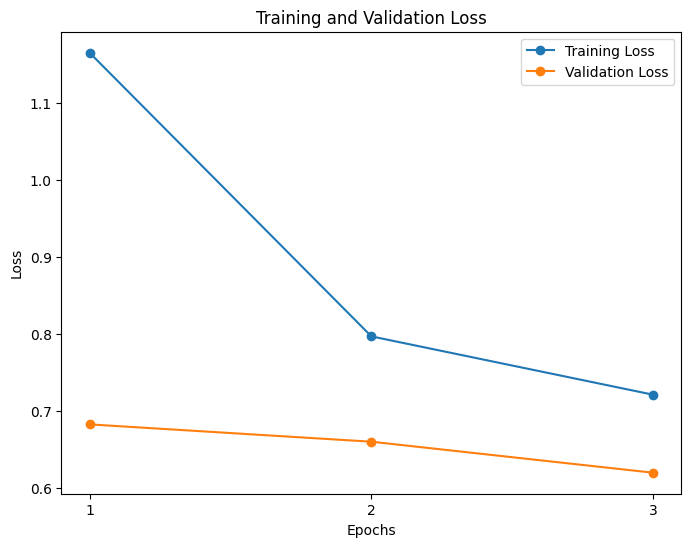

In [16]:
plt.figure(figsize=(8, 6))
plt.plot(epochs, loss, marker = 'o', label = "Training Loss")
plt.plot(epochs, val_loss, marker = 'o', label = "Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.xticks(epochs)
plt.ylabel("Loss")
plt.legend()
plt.show()

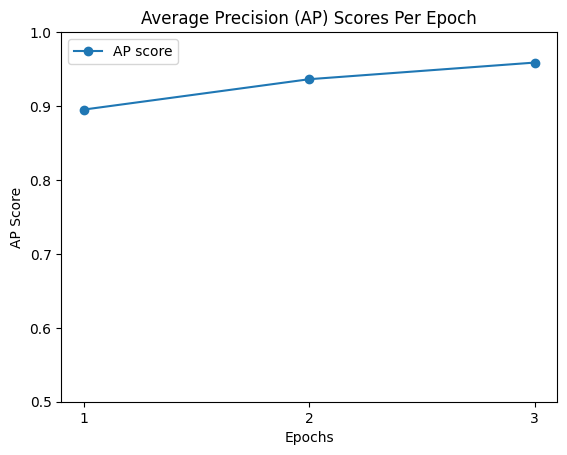

In [17]:
ap_scores_ho = best_history['holdout_ap']
plt.plot(epochs, ap_scores_ho, marker = 'o', label = "AP score")
plt.title("Average Precision (AP) Scores Per Epoch")
plt.xlabel("Epochs")
plt.xticks(epochs)
plt.ylabel("AP Score")
plt.ylim(0.5, 1.0)  # For clear scaling
plt.legend()
plt.show()

In [18]:
roc_auc_scores = best_history['holdout_roc_auc']

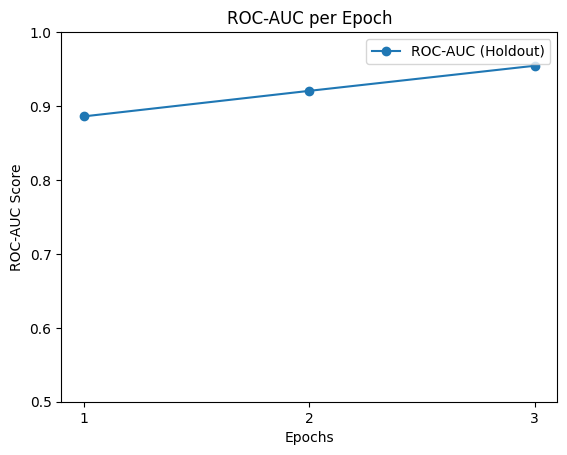

In [19]:
plt.plot(epochs, roc_auc_scores, marker='o', label='ROC-AUC (Holdout)')
plt.title('ROC-AUC per Epoch')
plt.xlabel('Epochs')
plt.ylabel('ROC-AUC Score')
plt.xticks(epochs)
plt.ylim(0.5, 1.0)  # For clear scaling
plt.legend()
plt.show()

In [20]:
x_ho, y_ho = ho_dataset

In [21]:
predicted_probs = best_model.predict(x_ho).ravel()

69/69 ━━━━━━━━━━━━━━━━━━━━ 8s 102ms/step


In [22]:
roc_auc_score_ho = roc_auc_score(y_ho, predicted_probs)
roc_auc_score_ho

0.954517206458103

In [23]:
# Calculate precision-recall pairs for different thresholds
precision, recall, thresholds = precision_recall_curve(y_ho, predicted_probs)

# Compute the area under the curve (AUC)
pr_auc = auc(recall, precision)
pr_auc

0.9587829433371764

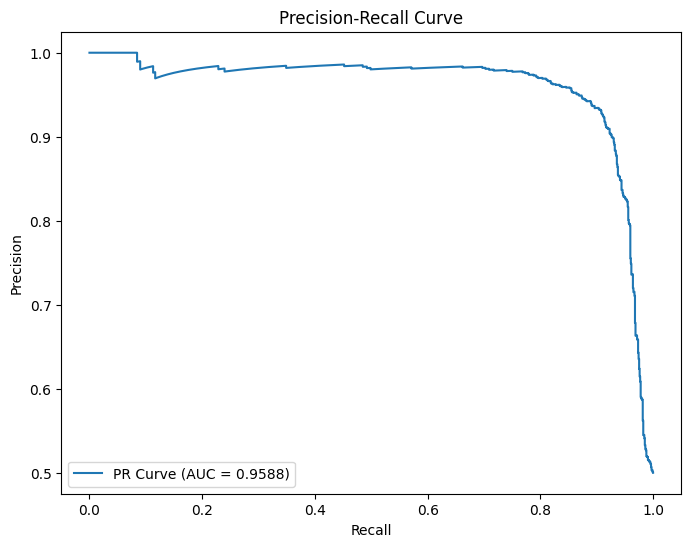

In [24]:
# Plot the precision-recall curve
plt.figure(figsize = (8, 6))
plt.plot(recall, precision, label = f'PR Curve (AUC = {pr_auc:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc ='lower left')
plt.show()

In [25]:
# Compute false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_ho, predicted_probs)

# Compute the ROC AUC score
roc_auc = roc_auc_score(y_ho, predicted_probs)
roc_auc

0.954517206458103

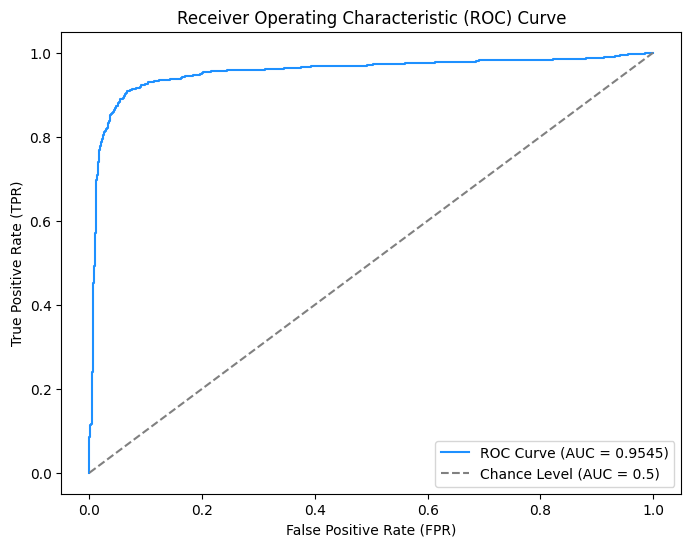

In [26]:
# Plot the ROC curve
plt.figure(figsize = (8, 6))
plt.plot(fpr, tpr, label = f'ROC Curve (AUC = {roc_auc:.4f})', color = 'dodgerblue')
plt.plot([0, 1], [0, 1], linestyle = '--', color = 'gray', label = 'Chance Level (AUC = 0.5)')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc = 'lower right')
plt.show()

In [27]:
preds = (predicted_probs > 0.5).astype(int)

In [28]:
conf_matrix = confusion_matrix(y_ho, preds)

In [29]:
print(classification_report(y_ho, preds))

              precision    recall  f1-score   support

           0       0.93      0.89      0.91      1089
           1       0.89      0.93      0.91      1089

    accuracy                           0.91      2178
   macro avg       0.91      0.91      0.91      2178
weighted avg       0.91      0.91      0.91      2178



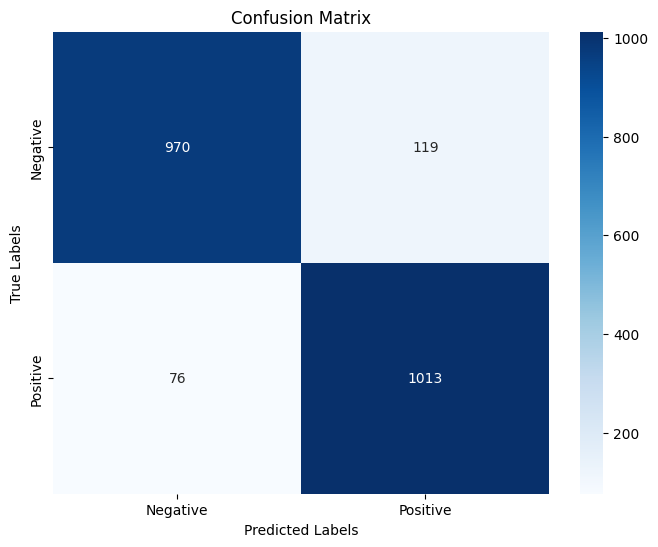

In [30]:
class_names = ['Negative', 'Positive']

# Plot the confusion matrix
plt.figure(figsize = (8, 6))
sns.heatmap(conf_matrix, annot = True, fmt = 'd', cmap = 'Blues', xticklabels = class_names, yticklabels = class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

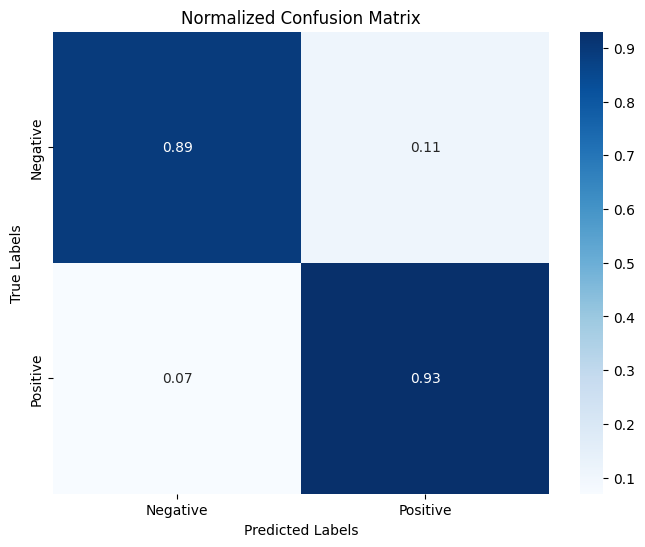

In [31]:
# Normalize the confusion matrix
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Plot the normalized confusion matrix
plt.figure(figsize = (8, 6))
sns.heatmap(conf_matrix_normalized, annot = True, fmt = '.2f', cmap = 'Blues', xticklabels = class_names, yticklabels = class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Normalized Confusion Matrix')
plt.show()

We will download our results after the end of our modeling / analysis.

In [32]:
files.download('/content/wids_gs_best_train_history.json')
files.download('/content/wids_gs_results.csv')
files.download('/content/wids_gs_best_mod.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **Fine Tuning**

In [79]:
# Define the same custom callback but separately for fine tuning
class PrecisionRecallHoldoutCallback_tuned(tf.keras.callbacks.Callback):
    def __init__(self, holdout_data):
        self.holdout_data = holdout_data  # Holdout data (X, y)
        self.precision_0 = []
        self.recall_0 = []
        self.f1_0 = []  # F1 score for Class 0
        self.precision_1 = []
        self.recall_1 = []
        self.f1_1 = []  # F1 score for Class 1
        self.roc_auc_scores = []  # ROC-AUC scores across epochs
        self.ap_scores = [] # AP scores across epochs

    def on_epoch_end(self, epoch, logs=None):
        x_holdout, y_holdout = self.holdout_data
        predictions = self.model.predict(x_holdout).ravel() # Flatten out
        predictions_binary = (predictions > 0.5).astype(int)  # Convert probabilities to binary predictions

        # Compute metrics for Class 0
        precision_0 = precision_score(y_holdout, predictions_binary, pos_label=0)
        recall_0 = recall_score(y_holdout, predictions_binary, pos_label=0)
        f1_0 = f1_score(y_holdout, predictions_binary, pos_label=0)

        # Compute metrics for Class 1
        precision_1 = precision_score(y_holdout, predictions_binary, pos_label=1)
        recall_1 = recall_score(y_holdout, predictions_binary, pos_label=1)
        f1_1 = f1_score(y_holdout, predictions_binary, pos_label=1)

        # Compute ROC-AUC score
        roc_auc = roc_auc_score(y_holdout, predictions)
        # Compute Average Precision (AP) score
        ap_score = average_precision_score(y_holdout, predictions)

        # Log metrics
        print(f"\nEpoch {epoch + 1}: Holdout Precision (Class 0) = {precision_0:.4f}, Recall (Class 0) = {recall_0:.4f}, F1 (Class 0) = {f1_0:.4f}")
        print(f"Epoch {epoch + 1}: Holdout Precision (Class 1) = {precision_1:.4f}, Recall (Class 1) = {recall_1:.4f}, F1 (Class 1) = {f1_1:.4f}")
        print(f"Epoch {epoch + 1}: Holdout ROC-AUC Score = {roc_auc:.4f}, Average Precision (AP) Score = {ap_score:.4f}")

        # Append metrics to lists
        self.precision_0.append(precision_0)
        self.recall_0.append(recall_0)
        self.f1_0.append(f1_0)
        self.precision_1.append(precision_1)
        self.recall_1.append(recall_1)
        self.f1_1.append(f1_1)
        self.roc_auc_scores.append(roc_auc)
        self.ap_scores.append(ap_score)

        # Optionally store metrics in logs for further analysis
        logs['holdout_precision_0'] = precision_0
        logs['holdout_recall_0'] = recall_0
        logs['holdout_f1_0'] = f1_0
        logs['holdout_precision_1'] = precision_1
        logs['holdout_recall_1'] = recall_1
        logs['holdout_f1_1'] = f1_1
        logs['holdout_roc_auc'] = roc_auc
        logs['holdout_ap'] = ap_score

We will train our saved model for two additional epochs but at a lower learning rate.

In [55]:
best_score_tuned = None
best_params_tuned = None
best_history_tuned = None
best_metrics_tuned = None
results_tuned = []

for layer in best_model.layers:
  layer.trainable = True

# Compile
best_model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate = 1e-5, weight_decay = 5e-5),
            loss='binary_crossentropy',
            metrics=['accuracy', tf.keras.metrics.AUC(name='roc_auc', curve='ROC')])

# Train
holdout_callback_tuned = PrecisionRecallHoldoutCallback_tuned((x_holdout, y_holdout))
history_tuned = best_model.fit(
  train_dataset,
  epochs=2,
  validation_data=val_dataset,
  callbacks=[holdout_callback_tuned],
  verbose=1
)

# Evaluate
roc_auc_score_ho = holdout_callback_tuned.roc_auc_scores[-1]
ap_score = holdout_callback_tuned.ap_scores[-1]
f1_class_0 = holdout_callback_tuned.f1_0[-1]
f1_class_1 = holdout_callback_tuned.f1_1[-1]
avg_f1_score = (f1_class_0 + f1_class_1) / 2


x_holdout, y_holdout = ho_dataset
predictions = model.predict(x_holdout)
predictions = (predictions > 0.5).astype(int)

precision_0 = precision_score(y_holdout, predictions, pos_label=0)
recall_0 = recall_score(y_holdout, predictions, pos_label=0)

precision_1 = precision_score(y_holdout, predictions, pos_label=1)
recall_1 = recall_score(y_holdout, predictions, pos_label=1)

print(f"ROC-AUC = {roc_auc_score_ho:.4f}, "
    f"F1 (Class 0) = {f1_class_0:.4f}, F1 (Class 1) = {f1_class_1:.4f}, "
    f"AP score = {ap_score:.4f}, "
    f"Average F1 Score = {avg_f1_score:.4f}")

# Append results
results_tuned.append({
  'roc_auc': roc_auc_score_ho,
  'ap_score': ap_score,
  'f1_class_0': f1_class_0,
  'f1_class_1': f1_class_1,
  'avg_f1_score': avg_f1_score,
  'precision_0': precision_0,
  'recall_0': recall_0,
  'precision_1': precision_1,
  'recall_1': recall_1
})

# Track best metrics
if best_score_tuned is None or avg_f1_score > best_score_tuned:
  print("\nUpdating best model.\n")
  best_score_tuned = avg_f1_score
  best_metrics_tuned = [precision_0, recall_0, precision_1, recall_1, f1_class_0, f1_class_1, ap_score]
  best_history_tuned = history_tuned.history  # Save the training history of the best model
  best_model.save('wids_gs_best_mod_tuned.keras')  # Save the best model

# Clear session
tf.keras.backend.clear_session()

# Save results and best history
pd.DataFrame(results_tuned).to_csv('wids_gs_results_tuned.csv', index=False)
with open('wids_gs_best_train_history_tuned.json', 'w') as f:
  json.dump(best_history_tuned, f)

print(f"Best holdout metrics: Precision_0 = {best_metrics_tuned[0]:.4f}, Recall_0 = {best_metrics_tuned[1]:.4f}, "
    f"Precision_1 = {best_metrics_tuned[2]:.4f}, Recall_1 = {best_metrics_tuned[3]:.4f}, "
    f"F1_0 = {best_metrics_tuned[4]:.4f}, F1_1 = {best_metrics_tuned[5]:.4f}, "
    f"AP score = {best_metrics_tuned[6]:.4f}")

Epoch 1/2
69/69 ━━━━━━━━━━━━━━━━━━━━ 8s 99ms/step

Epoch 1: Holdout Precision (Class 0) = 0.9048, Recall (Class 0) = 0.8898, F1 (Class 0) = 0.8972
Epoch 1: Holdout Precision (Class 1) = 0.8916, Recall (Class 1) = 0.9063, F1 (Class 1) = 0.8989
Epoch 1: Holdout ROC-AUC Score = 0.9599, Average Precision (AP) Score = 0.9613
238/238 ━━━━━━━━━━━━━━━━━━━━ 103s 376ms/step - accuracy: 0.6617 - loss: 0.6630 - roc_auc: 0.7237 - val_accuracy: 0.7476 - val_loss: 0.5901 - val_roc_auc: 0.7903 - holdout_precision_0: 0.9048 - holdout_recall_0: 0.8898 - holdout_f1_0: 0.8972 - holdout_precision_1: 0.8916 - holdout_recall_1: 0.9063 - holdout_f1_1: 0.8989 - holdout_roc_auc: 0.9599 - holdout_ap: 0.9613
Epoch 2/2
69/69 ━━━━━━━━━━━━━━━━━━━━ 6s 86ms/step

Epoch 2: Holdout Precision (Class 0) = 0.9008, Recall (Class 0) = 0.9421, F1 (Class 0) = 0.9210
Epoch 2: Holdout Precision (Class 1) = 0.9394, Recall (Class 1) = 0.8962, F1 (Class 1) = 0.9173
Epoch 2: Holdout ROC-AUC Score = 0.9701, Average Precision (AP) Sco

In [103]:
best_model_tuned = load_model('/content/wids_gs_best_mod_tuned.keras')

In [150]:
best_model_tuned.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 82,913,207 (316.29 MB)

 Trainable params: 27,637,735 (105.43 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 55,275,472 (210.86 MB)

In [84]:
with open('wids_gs_best_train_history_tuned.json', 'r') as f:
    best_history_tuned_loaded = json.load(f)

In [85]:
best_history_tuned_loaded

{'accuracy': [0.6772068738937378, 0.7143610119819641],
 'loss': [0.6420944333076477, 0.5886056423187256],
 'roc_auc': [0.7397038340568542, 0.7777901291847229],
 'val_accuracy': [0.7476291060447693, 0.7534246444702148],
 'val_loss': [0.590070903301239, 0.5655796527862549],
 'val_roc_auc': [0.7903310656547546, 0.8014987111091614],
 'holdout_precision_0': [0.9047619047619048, 0.9007901668129938],
 'holdout_recall_0': [0.8898071625344353, 0.9421487603305785],
 'holdout_f1_0': [0.8972222222222223, 0.9210053859964094],
 'holdout_precision_1': [0.8915989159891599, 0.9393647738209817],
 'holdout_recall_1': [0.90633608815427, 0.8962350780532599],
 'holdout_f1_1': [0.8989071038251366, 0.9172932330827067],
 'holdout_roc_auc': [0.9598902456403083, 0.9701480958681058],
 'holdout_ap': [0.9613475389718612, 0.9721394468742387]}

In [86]:
loss_tuned = best_history_tuned_loaded['loss']
val_loss_tuned = best_history_tuned_loaded['val_loss']
epochs_tuned = range(1, len(loss_tuned) + 1)

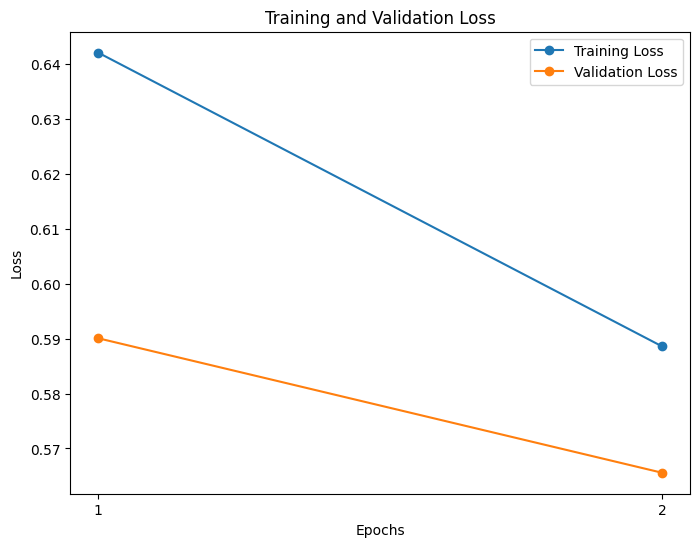

In [169]:
# Plot training and validation losses, fine tuned
plt.figure(figsize=(8, 6))
plt.plot(epochs_tuned, loss_tuned, marker = 'o', label = "Training Loss")
plt.plot(epochs_tuned, val_loss_tuned, marker = 'o', label = "Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.xticks(epochs_tuned)
plt.ylabel("Loss")
plt.legend()
plt.show()

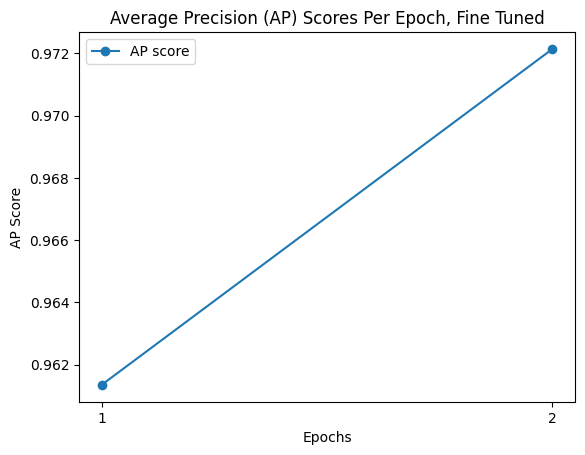

In [168]:
# Plot AP scores per epoch, fine tuned
ap_scores_ho_tuned = best_history_tuned_loaded['holdout_ap']
plt.plot(epochs_tuned, ap_scores_ho_tuned, marker = 'o', label = "AP score")
plt.title("Average Precision (AP) Scores Per Epoch, Fine Tuned")
plt.xlabel("Epochs")
plt.xticks(epochs_tuned)
plt.ylabel("AP Score")
plt.legend()
plt.show()

In [154]:
roc_auc_scores_tuned = best_history_tuned['holdout_roc_auc']

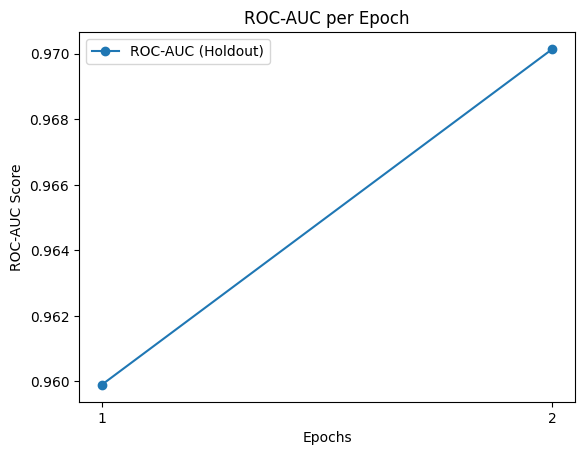

In [167]:
# Plot ROC-AUC per Epoch, fine tuned
plt.plot(epochs_tuned, roc_auc_scores_tuned, marker='o', label='ROC-AUC (Holdout)')
plt.title('ROC-AUC per Epoch')
plt.xlabel('Epochs')
plt.ylabel('ROC-AUC Score')
plt.xticks(epochs_tuned)
plt.legend()
plt.show()

In [89]:
predicted_probs_tuned = best_model_tuned.predict(x_ho).ravel()

69/69 ━━━━━━━━━━━━━━━━━━━━ 8s 95ms/step


In [90]:
roc_auc_score_ho_tuned = roc_auc_score(y_ho, predicted_probs_tuned)
roc_auc_score_ho_tuned

0.9701480958681058

In [91]:
# Calculate precision-recall pairs for different thresholds, fine tuned
precision_tuned, recall_tuned, thresholds_tuned = precision_recall_curve(y_ho, predicted_probs_tuned)

# Compute the area under the curve (AUC), fine tuned
pr_auc_tuned = auc(recall_tuned, precision_tuned)
pr_auc_tuned

0.9721254913314007

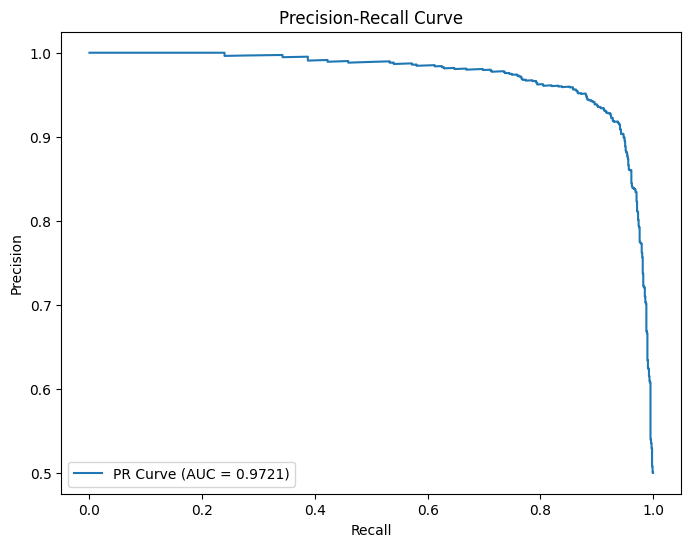

In [165]:
# Plot the precision-recall curve, fine tuned
plt.figure(figsize = (8, 6))
plt.plot(recall_tuned, precision_tuned, label = f'PR Curve (AUC = {pr_auc_tuned:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc ='lower left')
plt.show()

In [93]:
# Compute false positive rate, true positive rate, and thresholds, fine tuned
fpr_tuned, tpr_tuned, thresholds_tuned = roc_curve(y_ho, predicted_probs_tuned)

# Compute the ROC AUC score, fine tuned
roc_auc_tuned = roc_auc_score(y_ho, predicted_probs_tuned)
roc_auc_tuned

0.9701480958681058

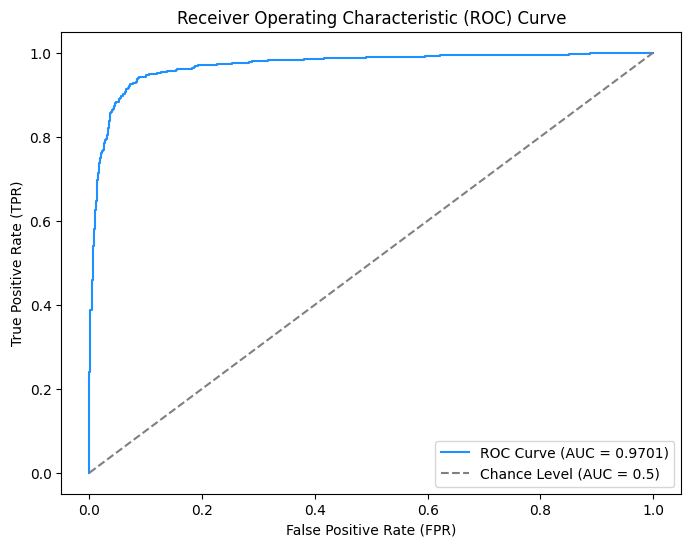

In [164]:
# Plot the ROC curve, fine tuned
plt.figure(figsize = (8, 6))
plt.plot(fpr_tuned, tpr_tuned, label = f'ROC Curve (AUC = {roc_auc_tuned:.4f})', color = 'dodgerblue')
plt.plot([0, 1], [0, 1], linestyle = '--', color = 'gray', label = 'Chance Level (AUC = 0.5)')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc = 'lower right')
plt.show()

In [95]:
preds_tuned = (predicted_probs_tuned > 0.5).astype(int)

In [96]:
conf_matrix_tuned = confusion_matrix(y_ho, preds_tuned)

In [97]:
print(classification_report(y_ho, preds_tuned))

              precision    recall  f1-score   support

           0       0.90      0.94      0.92      1089
           1       0.94      0.90      0.92      1089

    accuracy                           0.92      2178
   macro avg       0.92      0.92      0.92      2178
weighted avg       0.92      0.92      0.92      2178



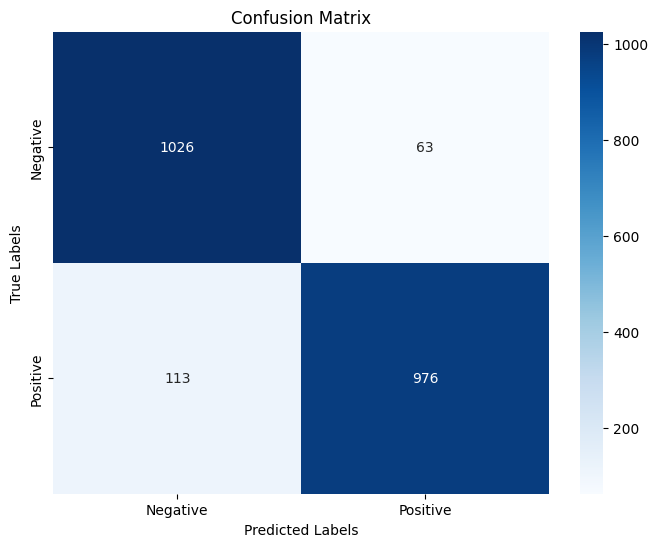

In [98]:
# Plot the confusion matrix, fine tuned
plt.figure(figsize = (8, 6))
sns.heatmap(conf_matrix_tuned, annot = True, fmt = 'd', cmap = 'Blues', xticklabels = class_names, yticklabels = class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

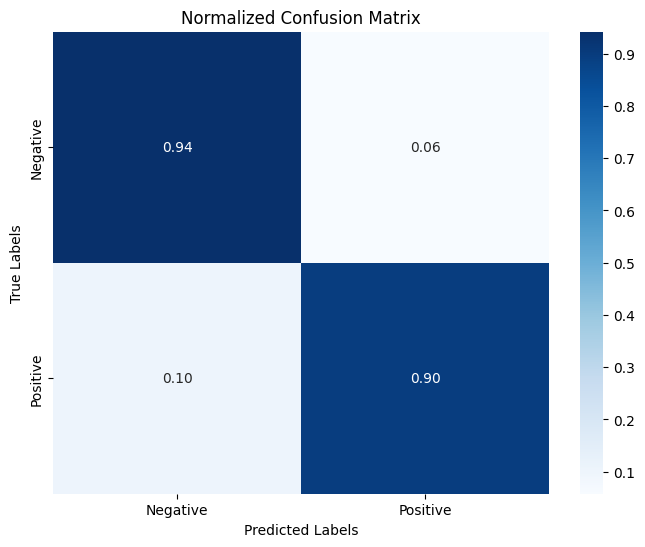

In [99]:
# Normalize the confusion matrix, fine tuned
conf_matrix_normalized_tuned = conf_matrix_tuned.astype('float') / conf_matrix_tuned.sum(axis=1)[:, np.newaxis]

# Plot the normalized confusion matrix, fine tuned
plt.figure(figsize = (8, 6))
sns.heatmap(conf_matrix_normalized_tuned, annot = True, fmt = '.2f', cmap = 'Blues', xticklabels = class_names, yticklabels = class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Normalized Confusion Matrix')
plt.show()

We will plot several metrics of our trained model but instead throughout all 5 epochs.

In [147]:
loss_total = loss + loss_tuned
val_loss_total = val_loss + val_loss_tuned
epochs_total = range(1, len(loss_total) + 1)

In [157]:
roc_auc_scores_total = roc_auc_scores + roc_auc_scores_tuned
ap_scores_total = ap_scores_ho + ap_scores_ho_tuned

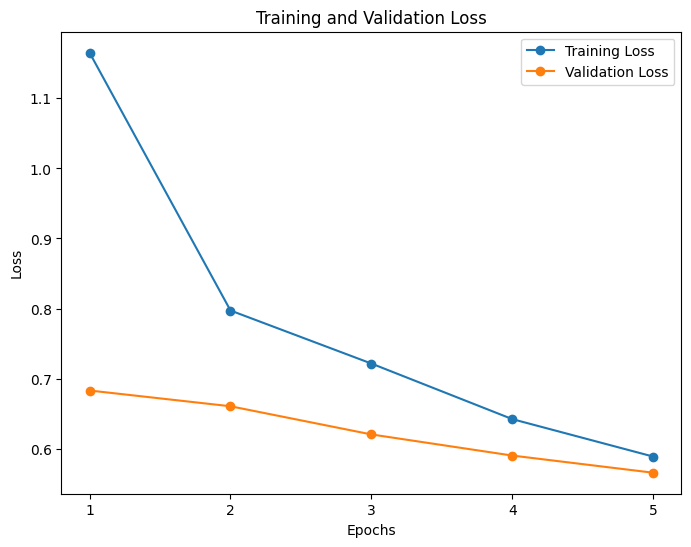

In [160]:
plt.figure(figsize=(8, 6))
plt.plot(epochs_total, loss_total, marker = 'o', label = "Training Loss")
plt.plot(epochs_total, val_loss_total, marker = 'o', label = "Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.xticks(epochs_total)
plt.ylabel("Loss")
plt.legend()
plt.show()

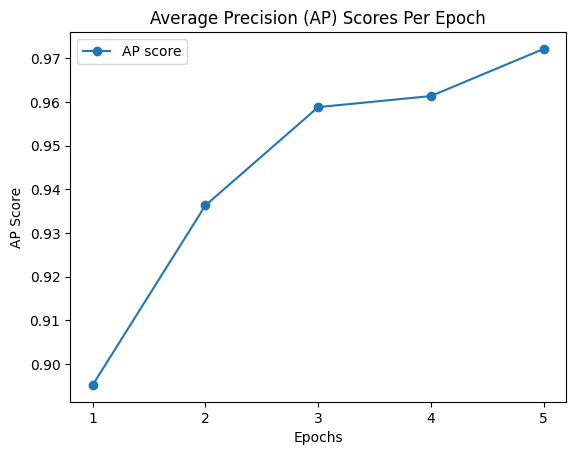

In [161]:
plt.plot(epochs_total, ap_scores_total, marker = 'o', label = "AP score")
plt.title("Average Precision (AP) Scores Per Epoch")
plt.xlabel("Epochs")
plt.xticks(epochs_total)
plt.ylabel("AP Score")
plt.legend()
plt.show()

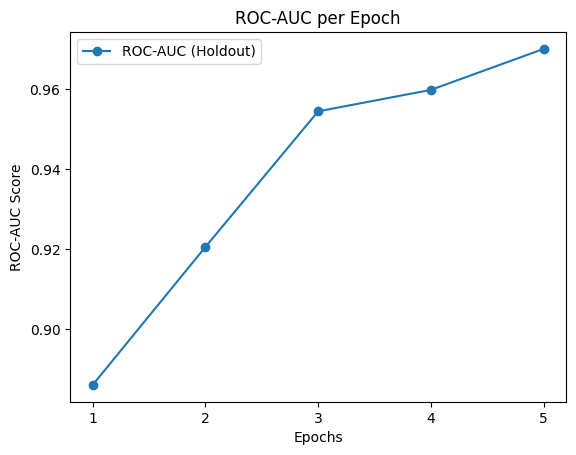

In [163]:
plt.plot(epochs_total, roc_auc_scores_total, marker='o', label='ROC-AUC (Holdout)')
plt.title('ROC-AUC per Epoch')
plt.xlabel('Epochs')
plt.ylabel('ROC-AUC Score')
plt.xticks(epochs_total)
plt.legend()
plt.show()